# CO460 - Deep Learning - Tutorial 4

## Introduction

Tutorial:
- Step-by-step implementation of an AE
- Guidelines for the VAE part of your coursework

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists('./tutorial_AE'):
    os.mkdir('./tutorial_AE')
    
def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

### Device selection

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [3]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

##  Autoencoders

###  Input normalization: 

$ x_{norm} = \frac{x-\mu}{\sigma} $

* We enforce $\mathbb{E}[x]$ = 0 and $Var(x) = 1$

**Range**:
* Input before normalization for MNIST dataset $\in [0,1]$. Input after normalization $\in [-1,1] $

$ \min{x_{norm}} = \frac{\min{(x)}-\mu}{\sigma} = \frac{0-0.5}{0.5} = -1 $, 
$ \max{(x_{norm})} = ... = 1 $


* Output should span the same interval $ \rightarrow$ Activation function of the output layer should be chosen carfeully (which one should we be using here?)
* Denormalization needs to be done in order to visualize

In [4]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))
])

def denorm_for_tanh(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

denorm = denorm_for_tanh

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("./data/", train=False, transform=transform)

### Hyper-parameter selection

In [5]:
num_epochs = 10
batch_size = 128
learning_rate = 1e-3
h_dim = 32
latent_dim = 32

### Define the dataloaders

In [6]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=16)

sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[:32, :, :, :]

in_dim = fixed_input.shape[-1] * fixed_input.shape[-2]

save_image(fixed_input, './tutorial_AE/image_original.png')

### Define the model


In [7]:
class AE(nn.Module):
    def __init__(self, in_dim=784, latent_dim = 32):
        super(AE, self).__init__()


        self.encoder = nn.Sequential(
            nn.Linear(in_dim, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, in_dim),
            nn.Tanh()
            )
        
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon
    
AE_mnist = AE(latent_dim = latent_dim)

### Define Loss function

In [8]:
criterion = nn.L1Loss(reduction='sum')  # can we use any other loss here?
def loss_function_AE(recon_x, x):
    recon_loss = criterion(recon_x, x)/x.shape[0]
    return recon_loss

### Initialize Model and print number of parameters

In [9]:
model = AE_mnist.to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))  # can you calculate them by hand?
print(model)

Total number of parameters is: 50992
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Tanh()
  )
)


### Choose and initialize optimizer

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 ### Train

In [11]:
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_AE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader.dataset)))
    recon = model(fixed_input.view(fixed_input.size(0), -1).to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './tutorial_AE/reconstructed_epoch_{}.png'.format(epoch))
    # save the model
    torch.save(model.state_dict(), './tutorial_AE/model.pth')

epoch [1/10], loss:1.4093
epoch [2/10], loss:0.8592
epoch [3/10], loss:0.7123
epoch [4/10], loss:0.6307
epoch [5/10], loss:0.5579
epoch [6/10], loss:0.5081
epoch [7/10], loss:0.4702
epoch [8/10], loss:0.4450
epoch [9/10], loss:0.4252
epoch [10/10], loss:0.4084


### Test

In [12]:
# load the model
model.load_state_dict(torch.load("./tutorial_AE/model.pth"))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (img, _) in enumerate(test_loader):
        img = img.view(img.size(0), -1)
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_AE(recon_batch, img)
    # reconstruct and save the last batch
    recon_batch = model(recon_batch.view(recon_batch.size(0), -1).to(device))
    # save the original last batch
    save_image(denorm(img.cpu()), './tutorial_AE/test_original.png')
    save_image(denorm(recon_batch.cpu()), './tutorial_AE/reconstructed_test.png')
    # loss calculated over the whole test set
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.3971


### Visualizations

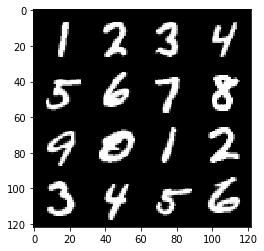

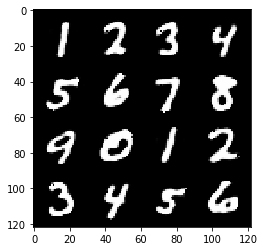

In [13]:
# visualize the original images of the last batch of the test set
plt.figure()
img = make_grid(denorm(img.cpu()), nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(img)

plt.figure()
# visualize the reconstructed images of the last batch of test set
recon_batch_denorm = denorm(recon_batch.view(-1, 1, 28, 28).cpu())
recon_batch_denorm = make_grid(recon_batch_denorm, nrow=4, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
show(recon_batch_denorm)

## Variational Autoencoders

## Define the model

### Reminder

We want to maximize the probability of our training data under the model:

* So, for a data sample $x_i$

$ \log{p_\theta(\mathbf{x_i})} \geq \mathbb{E}_{\mathbf{z_i}\sim q_\phi(\mathbf{z}\mid \mathbf{x_i})}[\log{p_\theta(\mathbf{x_i}|\mathbf{z_i})}] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z})) $

* And for the entire dataset:

$ \log{\mathbb{P}_\theta[\mathbf{X}]} = \sum_i {\log{p_\theta(\mathbf{x_i})}} \geq \sum_i \mathbb{E}_{\mathbf{z_i}\sim q_\phi(\mathbf{z}\mid \mathbf{x_i})}[{\log{p_\theta(\mathbf{x_i}|\mathbf{z_i})}] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z}))} $


* The expected values can be computed with Monte Carlo sampling. Here we assume that we sample one $\mathbf{z_i}$ from the approximate posterior q

### KL divergence (second term): 

If $  \mathbf{z_i}\sim\mathcal{N}(0,I) $, then:

$$ - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z})) = \frac{1}{2}\sum_{j=1}^J{(1+log(\sigma_{ij}^2)-\mu_{ij}^2-\sigma_{ij}^2)} $$ where $J$ the dimensionality of the latent space

(prove it for homework!)

1. **Encoder**:
Input $\mathbf{x}_i$ $\rightarrow$ Hidden Layers $\rightarrow$ $\mu_{ij},  \log(\sigma^2_{ij}) = 2\log(\sigma_{ij}) \, , \forall j$ 
2. **Decoder**:
$\mu_{ij}, \log(\sigma_{ij}^2) \rightarrow$ **Sample**: $z_{ij} = \epsilon_{ij} * \sigma_{ij}+\mu_{ij} = \epsilon_{ij} * e^{\frac{1}{2}\log(\sigma_{ij}^2)}+\mu_{ij} \rightarrow$  Hidden Layers $ \rightarrow$Output

### Reconstruction log-likelihood (first term): 

**Important Note:** The decoder is modelling a probability distribution. Thus in the discrete case it should output probabilites, whereas in the continuous, it should output the parameters of a parametric family:


**Example 1: binary variables**:

The probabilistic decoder predicts the probability of a sample being equal to 1.

$$\text{(1D case): } \sum_i\log{p(x_i|z_i;\theta)}=\sum_i\log{\mathcal{Be}(f(z_i))}$$

Thus, we are minimizing:

$\sum_i(x_i\log{f(z_i)}+(1-x_i)\log{(1-f(z_i))})$, where $x\in\{0,1\}$ : **Binary cross entropy**

**Example 2: continuous variables under gaussianity assumptions**:

The probabilistic decoder predicts the mean and the variance of the gaussian.

 $$\text{(1D case): } \sum_i\log{p(x_i|z_i;\theta)}=\sum_i\log{\mathcal{N}(\mu_i,\sigma_i^2)}= 
\sum_i(-\frac{(x_i-\mu_i)^2}{2\sigma_i^2} - \frac{1}{2}\log{2\pi \sigma_i^2})$$

Usually we omit the prediction of the variance and predict only the mean. Thus, we are minimizing:

$\sum_i(x_i-\mu_i)^2 = \sum_i(x_i-f(z_i))^2$ : **Mean Squared Error**



### Additional remarks: 

1. When we do batch training the loss should be the average loss of the samples of the batch

2. It is common to use a parameter $\beta$ as a weighting coefficient to balance the two terms of the loss:

$ \mathcal{L} = \sum_i \frac{1}{M} \big( \mathbb{E}_{\mathbf{z_i}\sim q_\phi(\mathbf{z}\mid \mathbf{x_i})}[{\log{p_\theta(\mathbf{x_i}|\mathbf{z_i})}] - \beta D_{KL}(q_\phi(\mathbf{z}|\mathbf{x_i})\|p_\theta(\mathbf{z}))\big)} $